In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
import warnings

In [203]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression

class ExponentialSmoothingWithExogenous:
    def __init__(self, trend=None, seasonal=None, seasonal_periods=None):
        """
        Initializes the hybrid model with optional parameters for Exponential Smoothing.

        Parameters:
        - trend: str, optional (default=None)
            Type of trend component ("add", "mul", or None).
        - seasonal: str, optional (default=None)
            Type of seasonal component ("add", "mul", or None).
        - seasonal_periods: int, optional
            The number of periods in a complete seasonal cycle.
        """
        self.trend = trend
        self.seasonal = seasonal
        self.seasonal_periods = seasonal_periods
        self.reg_model = LinearRegression()
        self.smoothing_model = None
        self.smoothing_fit = None
        self.residuals = None

    def fit(self, y, exog):
        """
        Fits the hybrid model to the data.

        Parameters:
        - y: array-like, shape (n_samples,)
            The target time series.
        - exog: array-like, shape (n_samples, n_features)
            Exogenous variables.

        Returns:
        - self: object
            Fitted model instance.
        """
        # Step 1: Fit regression model
        self.reg_model.fit(exog, y)
        predicted = self.reg_model.predict(exog)

        # Calculate residuals
        self.residuals = y - predicted

        # Step 2: Fit Exponential Smoothing to residuals
        self.smoothing_model = ExponentialSmoothing(
            self.residuals, trend=self.trend, seasonal=self.seasonal, seasonal_periods=self.seasonal_periods
        )
        self.smoothing_fit = self.smoothing_model.fit()
        return self

    def predict(self, exog):
        """
        Predicts the target variable using the fitted model.

        Parameters:
        - exog: array-like, shape (n_samples, n_features)
            Exogenous variables.

        Returns:
        - predictions: array-like, shape (n_samples,)
            Predicted values of the target variable.
        """
        # Predict using regression model
        predicted = self.reg_model.predict(exog)

        # Add smoothed residuals to regression predictions
        smoothed_residuals = self.smoothing_fit.fittedvalues
        return predicted + smoothed_residuals

    def forecast(self, steps, future_exog):
        """
        Forecasts the target variable for future time steps.

        Parameters:
        - steps: int
            Number of time steps to forecast.
        - future_exog: array-like, shape (steps, n_features)
            Future values of exogenous variables.

        Returns:
        - forecast: array-like, shape (steps,)
            Forecasted values of the target variable.
        """
        # Predict using regression model for future exogenous values
        future_predicted = self.reg_model.predict(future_exog)

        # Forecast residuals using the Exponential Smoothing model
        forecasted_residuals = self.smoothing_fit.forecast(steps=steps)

        return future_predicted + forecasted_residuals

In [204]:
def plot(data, cols):
  # plot the time series data
  plt.figure(figsize=(15, 6))
  plt.plot(data[cols[0]], data[cols[1]])
  plt.title('TSF')
  plt.xlabel(cols[0])
  plt.ylabel(cols[1])
  plt.show()

In [236]:
def plot_model_results(train, test, forecast, forecast_train, label, cols):
    # Plot Exponential Smoothing results
    plt.figure(figsize=(15, 6))
    plt.plot(train[cols[0]], train[cols[1]], label="Train", color='blue')
    plt.plot(test[cols[0]], test[cols[1]], label="Test", color='green')
    plt.plot(train[cols[0]], forecast_train, label='In-sample Forecast', color='red')
    plt.plot(
        test[cols[0]],
        forecast,
        label=label,
        color="orange",
    )
    plt.legend(loc="best")
    # set y range to be 450,000 to 510,000
    plt.ylim(440000, 520000)
    plt.show()

In [206]:
def evaluate_model(test, forecast):
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    return rmse, mae

# Data: House Property Sale

In [207]:
loaded_data = pd.read_csv('house.csv')

In [208]:
loaded_data

,saledate,price,type,bedrooms
0,30/09/2007,441854,house,2
1,31/12/2007,441854,house,2
2,31/03/2008,441854,house,2
3,30/06/2008,441854,house,2
4,30/09/2008,451583,house,2
...,...,...,...,...
342,30/09/2018,603281,flat,3
343,31/12/2018,601167,flat,3
344,31/03/2019,605637,flat,3
345,30/06/2019,599339,flat,3


In [209]:
print(loaded_data['type'].unique())
# one-hot encoding for 'type' - 'house' - 1, 'flat' - 0
loaded_data['type'] = loaded_data['type'].map({'house': 1, 'flat': 0})

['house' 'flat']


In [210]:
loaded_data

,saledate,price,type,bedrooms
0,30/09/2007,441854,1,2
1,31/12/2007,441854,1,2
2,31/03/2008,441854,1,2
3,30/06/2008,441854,1,2
4,30/09/2008,451583,1,2
...,...,...,...,...
342,30/09/2018,603281,0,3
343,31/12/2018,601167,0,3
344,31/03/2019,605637,0,3
345,30/06/2019,599339,0,3


In [211]:
# loaded_data['date'] = pd.to_datetime(loaded_data['date'])
loaded_data['date'] = pd.to_datetime(loaded_data['saledate'])
# convert '30-11-2018 23:58' to '2018-11-30 23:58'
# loaded_data['date'] = pd.to_datetime(loaded_data['noted_date'], format='%d-%m-%Y %H:%M')

/var/folders/jc/v0k00k8d2js6zbcf3ngr1dyc0000gn/T/ipykernel_24101/483552914.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  loaded_data['date'] = pd.to_datetime(loaded_data['saledate'])


In [212]:
loaded_data

,saledate,price,type,bedrooms,date
0,30/09/2007,441854,1,2,2007-09-30
1,31/12/2007,441854,1,2,2007-12-31
2,31/03/2008,441854,1,2,2008-03-31
3,30/06/2008,441854,1,2,2008-06-30
4,30/09/2008,451583,1,2,2008-09-30
...,...,...,...,...,...
342,30/09/2018,603281,0,3,2018-09-30
343,31/12/2018,601167,0,3,2018-12-31
344,31/03/2019,605637,0,3,2019-03-31
345,30/06/2019,599339,0,3,2019-06-30


In [213]:
loaded_data = loaded_data[loaded_data.type == 1]
loaded_data=loaded_data[loaded_data['date']>='2010-01-01']
# limit to only houses for now for simplicity

In [214]:
cols = ['date', 'price', 'type', 'bedrooms']
data = loaded_data[cols]

In [215]:
data

,date,price,type,bedrooms
10,2010-03-31,459222,1,2
11,2010-06-30,456822,1,2
12,2010-09-30,457806,1,2
13,2010-12-31,459109,1,2
14,2011-03-31,460758,1,2
...,...,...,...,...
195,2018-09-30,1007114,1,5
196,2018-12-31,1002323,1,5
197,2019-03-31,998136,1,5
198,2019-06-30,995363,1,5


In [216]:
df=data.pivot(index='date', columns='bedrooms', values='price').interpolate(method='linear', limit_direction='both')
df.tail()

bedrooms,2,3,4,5
date,,,,
2018-09-30,504318,624602,830727,1007114
2018-12-31,506001,626608,820924,1002323
2019-03-31,496133,628423,811121,998136
2019-06-30,500158,630814,803925,995363
2019-09-30,510712,631875,791446,970268


In [217]:
# Reverse the pivot
df_unpivoted = df.reset_index().melt(id_vars='date', var_name='bedrooms', value_name='price')

# Reshape the DataFrame to the desired format
df_final = df_unpivoted.pivot(index='date', columns='bedrooms', values='price').reset_index()
# df_final.columns = ['date'] + [f"price_{col}" for col in sorted(df_final.columns[1:].astype(int), reverse=True)]
df_final.columns = ['date'] + [f"price_{col}" for col in sorted(df_final.columns[1:].astype(int))]

data = df_final.copy()
cols = list(data.columns)

df_final

,date,price_2,price_3,price_4,price_5
0,2010-03-31,459222,466433,599614,773355
1,2010-06-30,456822,474590,608528,776325
2,2010-09-30,457806,483176,615603,772699
3,2010-12-31,459109,491715,623105,775199
4,2011-03-31,460758,498022,628969,778470
5,2011-06-30,464788,503891,634155,789627
6,2011-09-30,467546,507090,636582,789614
7,2011-12-31,470333,507744,637421,790965
8,2012-03-31,470365,507449,635411,794533
9,2012-06-30,469149,507014,633695,792171


## price_2 (price of a 2 bedroom house) will be the KPI, while price_3, price_4 and price_5 will serve as exogenous variables

<Axes: xlabel='date'>

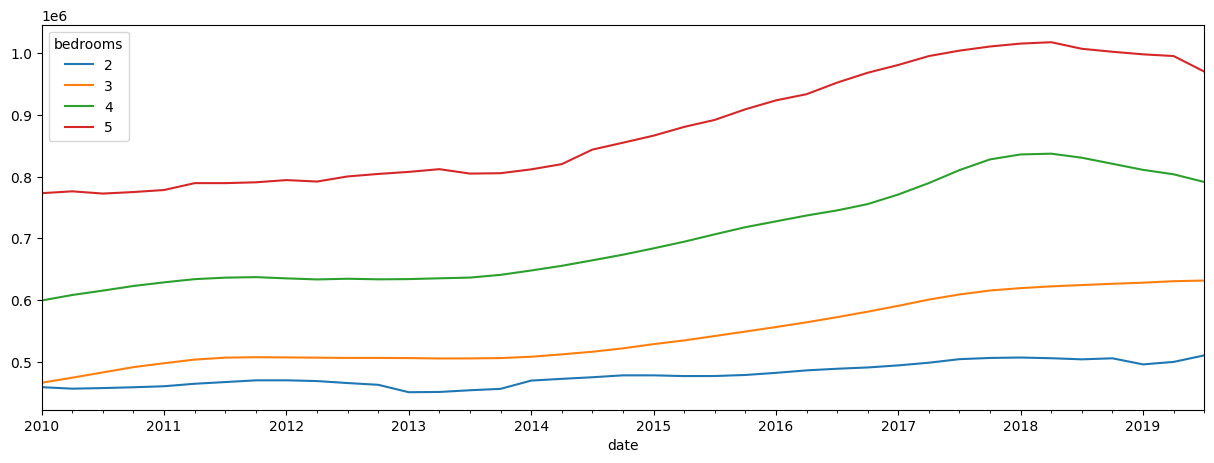

In [218]:
df.plot(figsize=(15,5))

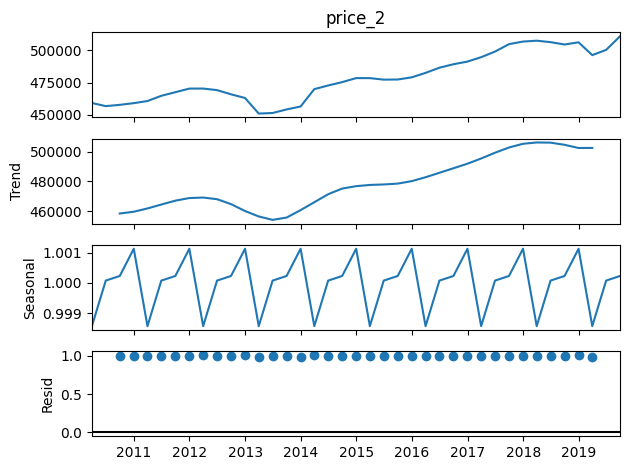

In [219]:
# seasonal decompose
result = seasonal_decompose(data.set_index(cols[0])[cols[1]], model='multiplicative', period=4)
result.plot()
plt.show()

## Testing the need for differencing by using the Augmented Dickey-Fuller test

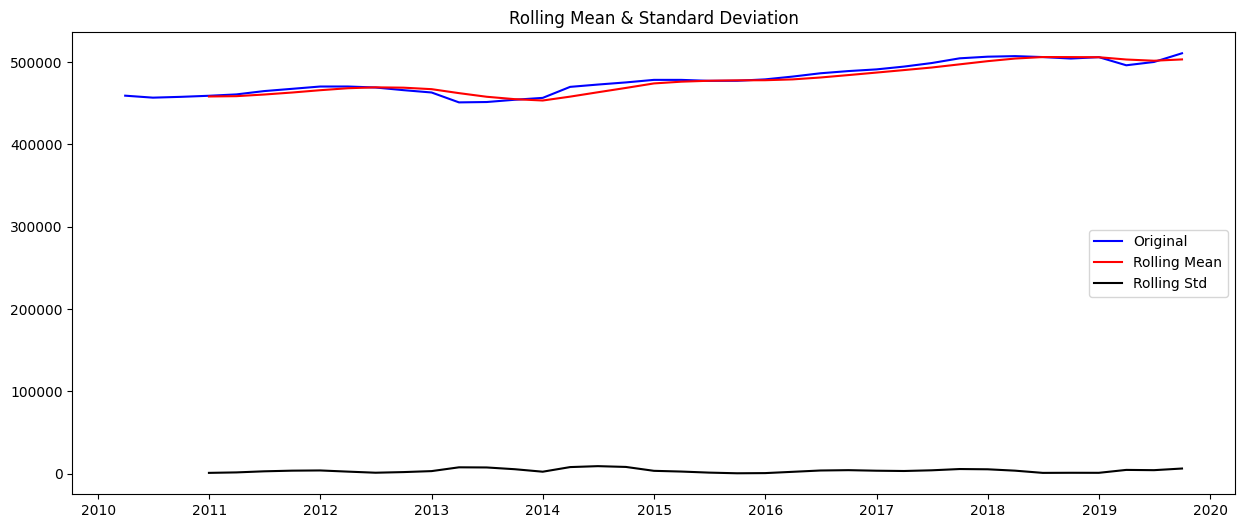

Results of Dickey-Fuller Test:
Test Statistic                  0.475386
p-value                         0.984105
#Lags Used                      4.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


In [220]:
# stationary test
def test_stationarity(timeseries, window=12):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Plot rolling statistics:
    plt.figure(figsize=(15, 6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(data.set_index(cols[0])[cols[1]], window=4)

## Differencing because p-value is greater than 0.05

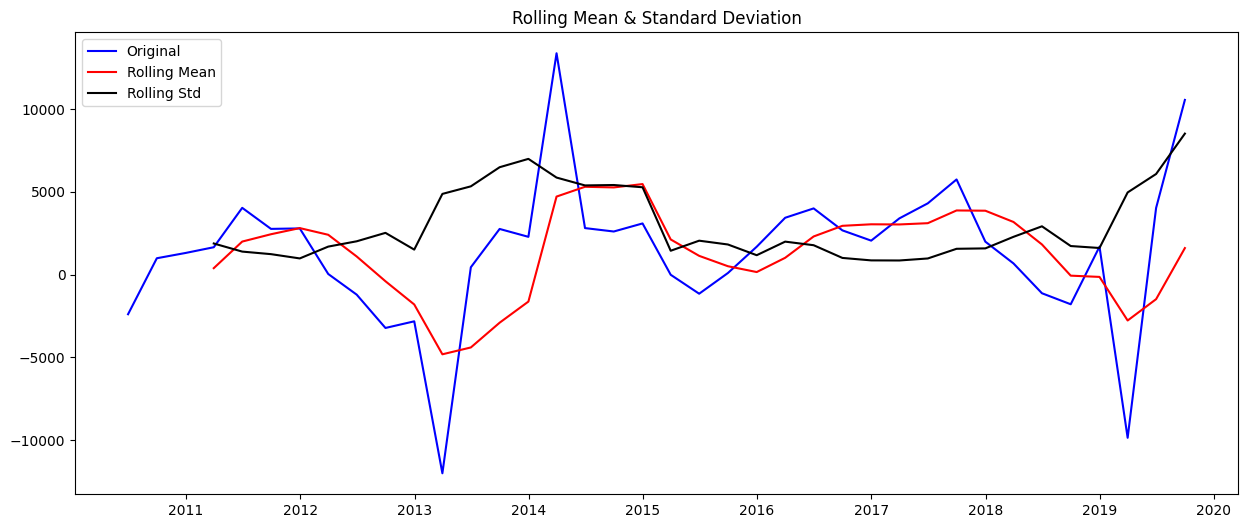

Results of Dickey-Fuller Test:
Test Statistic                 -4.070824
p-value                         0.001082
#Lags Used                      3.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


In [221]:
# the data is not stationary, we need to apply differencing
data['price_diff'] = data[cols[1]] - data[cols[1]].shift(1)
data.dropna(inplace=True)
test_stationarity(data.set_index(cols[0])['price_diff'], window=4)

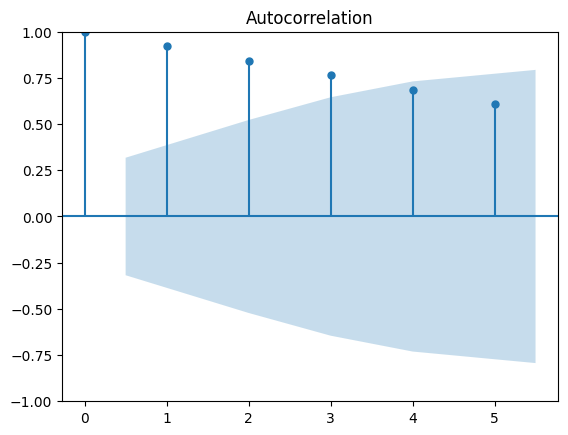

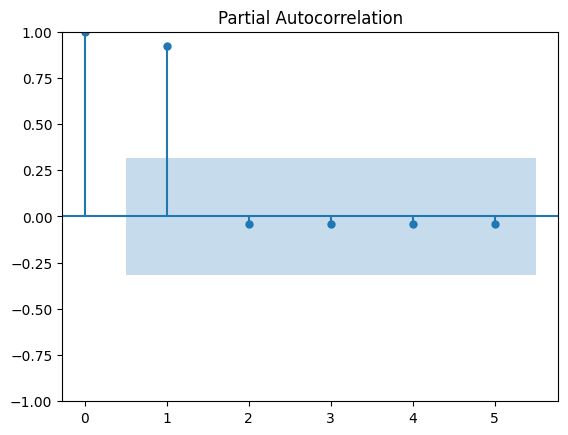

In [222]:
# generate ACF and PACF plots to determine the order of ARIMA model
col = cols[0]
plot_acf(data[col], lags=5)
plot_pacf(data[col], lags=5)
plt.show()

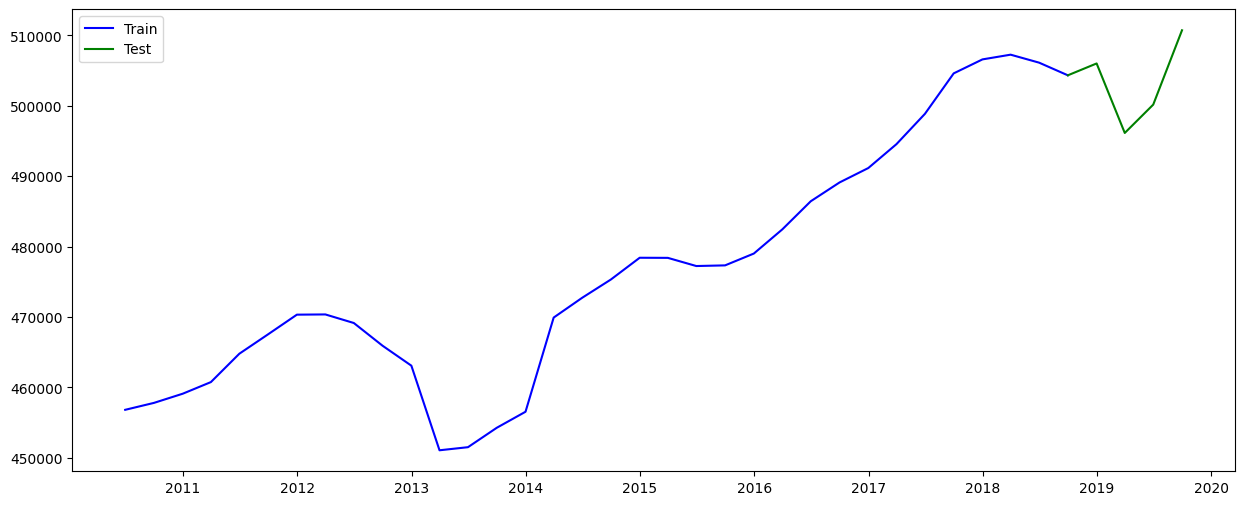

In [223]:
# train test split
train_size = int(len(data) * 0.9)
# train, test = data[:train_size], data[train_size:]
train, test = data[:train_size], data[train_size - 1 :]

# plot train and test data (with different colors - blue for train and green for test)
plt.figure(figsize=(15, 6))
plt.plot(train[cols[0]], train[cols[1]], label="Train", color="blue")
plt.plot(test[cols[0]], test[cols[1]], label="Test", color="green")
plt.legend(loc="best")
plt.show()

In [224]:
print(cols)
exog_train = train[cols[2:]]
# fill exog_test (with rows equal to the index of test) with the last train value of train data as test exog
# since we can't know the future values of these exog variables
last_train = train.iloc[-1]
exog_test = pd.DataFrame([last_train[cols[2:]]] * len(test), columns=cols[2:])
exog_train.head()

['date', 'price_2', 'price_3', 'price_4', 'price_5']


,price_3,price_4,price_5
1,474590,608528,776325
2,483176,615603,772699
3,491715,623105,775199
4,498022,628969,778470
5,503891,634155,789627


# Exponential Smoothing with exogenous 
### (exogenous varables are house prices with different no of bedrooms)

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without

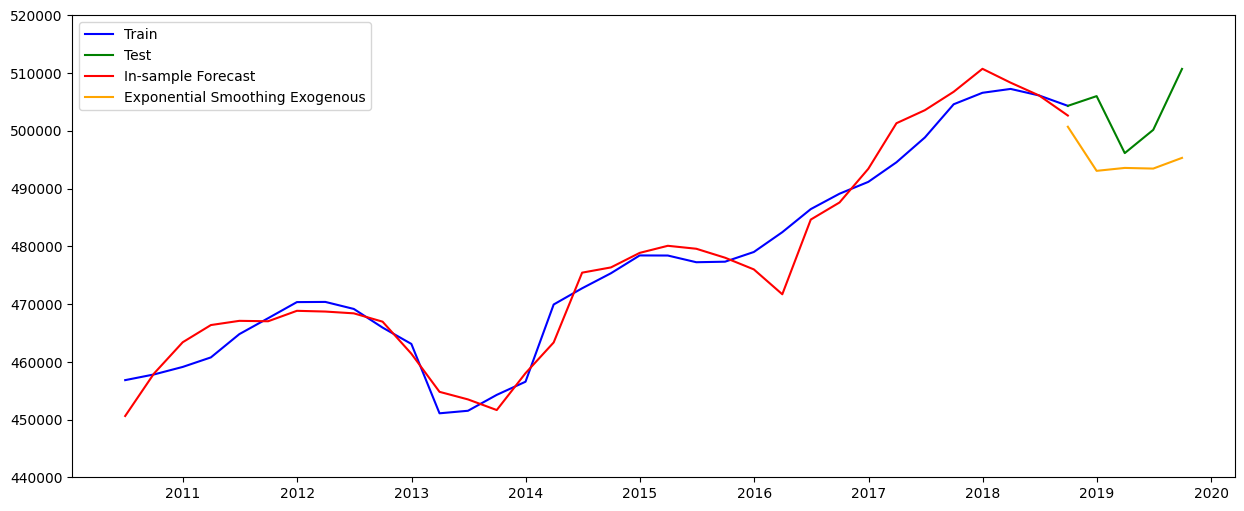

In [237]:
# our custom implementation of Exponential Smoothing with Exogenous variables
model_esx = ExponentialSmoothingWithExogenous(
    seasonal="add", seasonal_periods=12
)

# Fit the model
model_esx.fit(y=train[cols[1]], exog=exog_train)

# Forecast
forecast_esx = model_esx.forecast(steps=len(test), future_exog=exog_test)
forecast_train_esx = model_esx.predict(exog=exog_train)


plot_model_results(
    train=train,
    test=test,
    label="Exponential Smoothing Exogenous",
    forecast=forecast_esx,
    forecast_train=forecast_train_esx,
    cols=cols,
)

# ARX: Variant of Autoregression that supports Exogenous vars

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


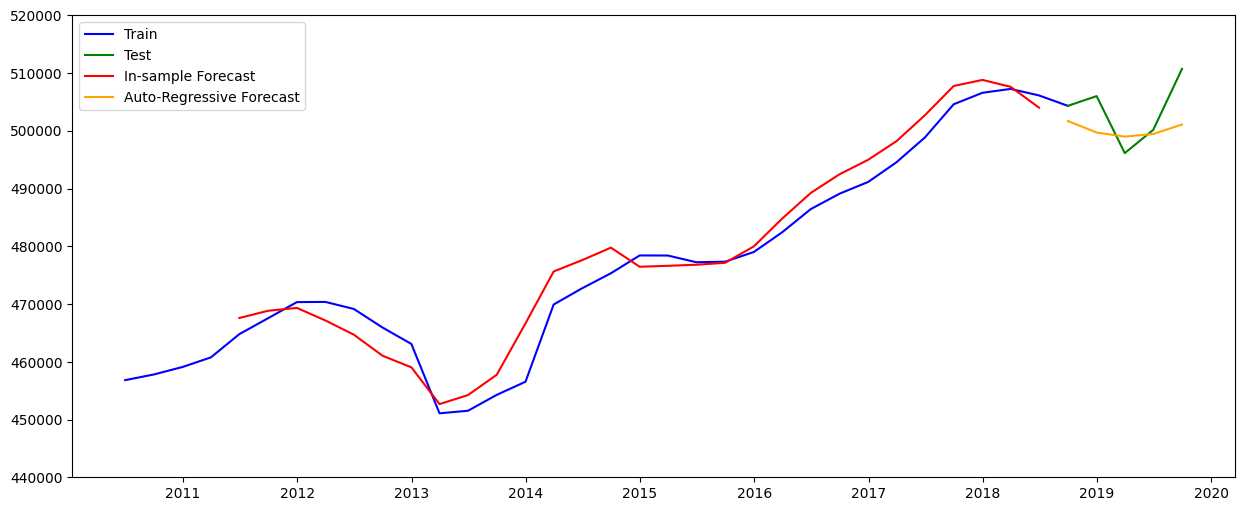

In [238]:
from statsmodels.tsa.ar_model import AutoReg

# Auto-Regressive Model
model_arx = AutoReg(train[cols[1]], lags=5, exog=exog_train).fit()
forecast_arx = model_arx.forecast(steps=len(test), exog=exog_test)
# predict in sample (train data)
forecast_train_arx = model_arx.predict(start=0, end=len(train) - 1)

plot_model_results(
    train=train,
    test=test,
    label="Auto-Regressive Forecast",
    forecast=forecast_arx,
    forecast_train=forecast_train_arx,
    cols=cols,
)

# MAX (Moving Average with Exogenous Variables)

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/sit

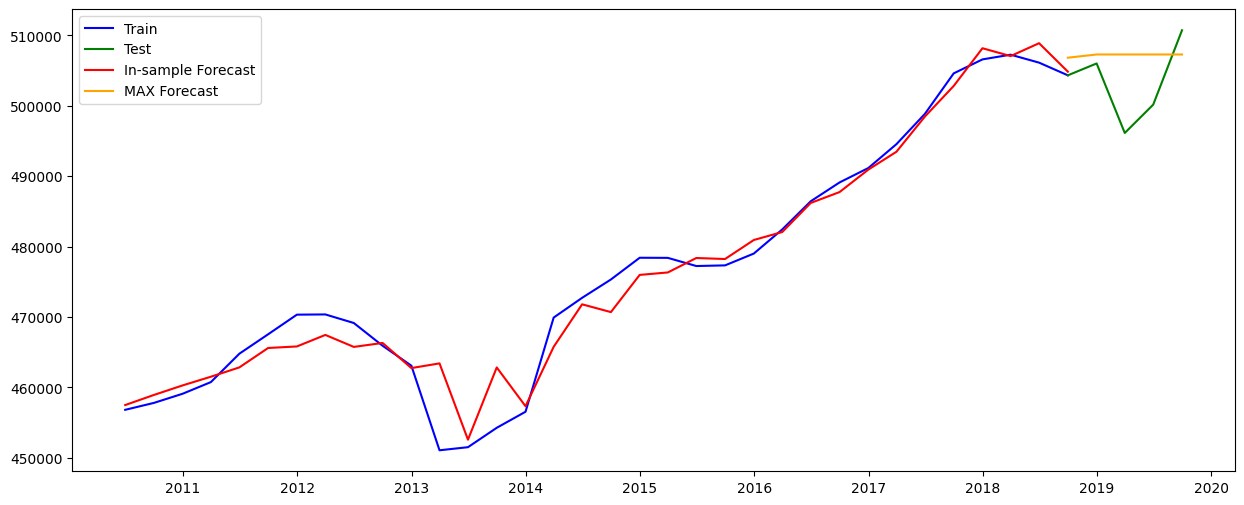

In [227]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an MA(1) model (ARIMA(0, 0, 1))
model_max = ARIMA(train[cols[1]], order=(0, 0, 1), exog=exog_train).fit()
forecast_max = model_max.forecast(steps=len(test), exog=exog_test)
# predict in sample (train data)
forecast_train_max = model_max.predict(start=0, end=len(train) - 1)

plot_model_results(
    train=train,
    test=test,
    label="MAX Forecast",
    forecast=forecast_max,
    forecast_train=forecast_train_max,
    cols=cols,
)

# ARIMAX
### Setting the 4 seasonal order variables (P,D,Q,S) to 0 in SARIMAX function makes it ARIMAX

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/sit

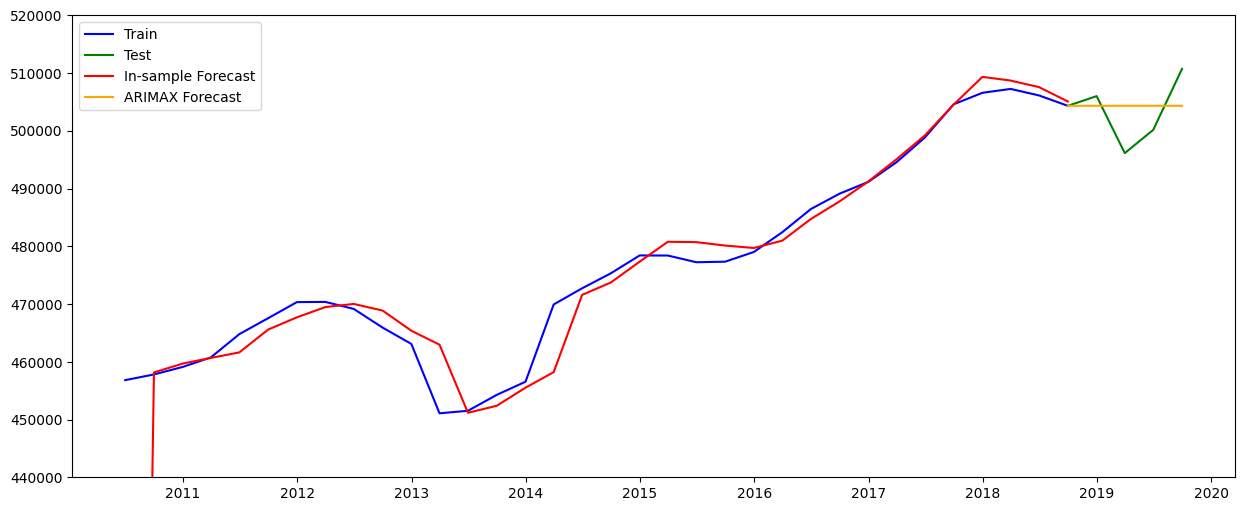

In [239]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# model_arimax = SARIMAX(train[cols[1]], exog=exog_train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)).fit()
model_arimax = ARIMA(train[cols[1]], order=(1, 1, 1), exog=exog_train).fit()
forecast_arimax = model_arimax.forecast(steps=len(test), exog=exog_test)
# predict in sample (train data)
forecast_train_arimax = model_arimax.predict(start=0, end=len(train) - 1, typ='levels')

plot_model_results(
    train=train,
    test=test,
    label="ARIMAX Forecast",
    forecast=forecast_arimax,
    forecast_train=forecast_train_arimax,
    cols=cols,
)

# SARIMAX

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20593D+01    |proj g|=  6.49354D+01

At iterate    5    f=  8.48843D+00    |proj g|=  7.58999D-01

At iterate   10    f=  8.41834D+00    |proj g|=  1.10855D-01

At iterate   15    f=  8.40546D+00    |proj g|=  3.37762D-01

At iterate   20    f=  8.40379D+00    |proj g|=  8.08521D-02

At iterate   25    f=  8.40315D+00    |proj g|=  2.34858D-01

At iterate   30    f=  8.40204D+00    |proj g|=  1.83144D-02

At iterate   35    f=  8.40201D+00    |proj g|=  1.70595D-02

At iterate   40    f=  8.40192D+00    |proj g|=  2.51542D-02

At iterate   45    f=  8.40154D+00    |proj g|=  6.28506D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


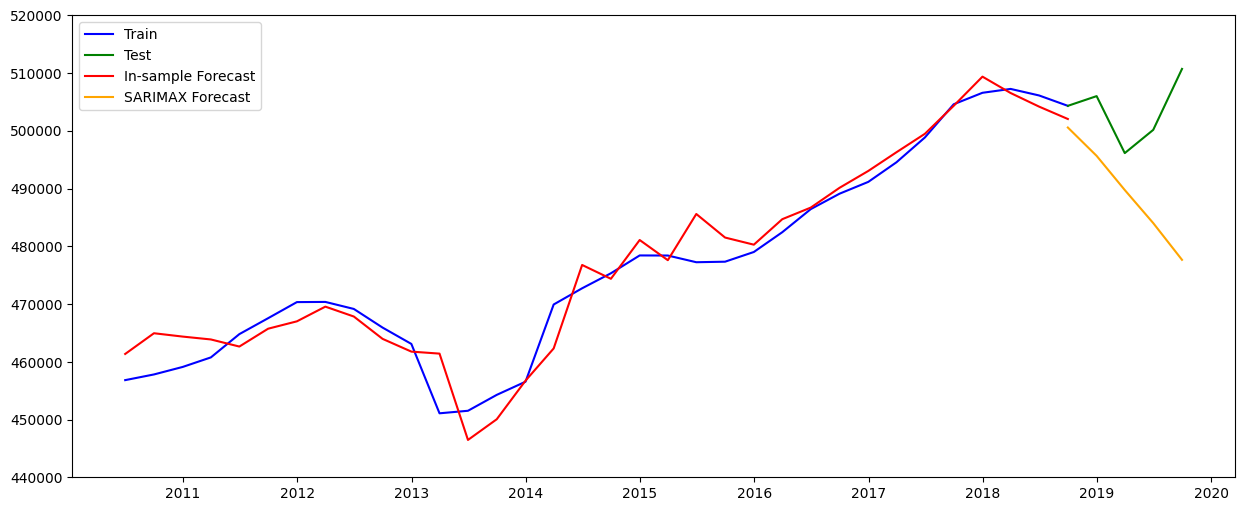

In [251]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA Model
model_sarimax = SARIMAX(train[cols[1]], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4), exog=exog_train).fit()
forecast_sarimax = model_sarimax.forecast(steps=len(test), exog=exog_test)
# predict in sample (train data)
forecast_train_sarimax = model_sarimax.predict(start=0, end=len(train) - 1, exog=exog_train)

plot_model_results(
    train=train,
    test=test,
    label="SARIMAX Forecast",
    forecast=forecast_sarimax,
    forecast_train=forecast_train_sarimax,
    cols=cols,
)

In [254]:
rmse_esx, mae_esx = evaluate_model(test[cols[1]], forecast_esx)
rmse_arx, mae_arx = evaluate_model(test[cols[1]], forecast_arx)
rmse_max, mae_max = evaluate_model(test[cols[1]], forecast_max)
rmse_arimax, mae_arimax = evaluate_model(test[cols[1]], forecast_arimax)
rmse_sarimax, mae_sarimax = evaluate_model(test[cols[1]], forecast_sarimax)

print(f"ESX: RMSE={rmse_esx}, MAE={mae_esx}")
print(f"ARX: RMSE={rmse_arx}, MAE={mae_arx}")
print(f"MAX: RMSE={rmse_max}, MAE={mae_max}")
print(f"ARIMAX: RMSE={rmse_arimax}, MAE={mae_arimax}")
print(f"SARIMAX: RMSE={rmse_sarimax}, MAE={mae_sarimax}")

ESX: RMSE=9688.244378013698, MAE=8246.103040042566
ARX: RMSE=5439.714816339035, MAE=4424.994606305763
MAX: RMSE=6236.742579607143, MAE=5093.899897893507
ARIMAX: RMSE=5061.442661295053, MAE=4085.748315490922
SARIMAX: RMSE=17408.78728151892, MAE=13937.547265534453
